References: 

[1] [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

- **random_num** is a high cardinality numerical variable (as many unique values as records).

- **random_cat** is a low cardinality categorical variable (3 possible values).

In [2]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="pandas")
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [3]:
X.columns

Index(['pclass', 'sex', 'embarked', 'random_cat', 'age', 'sibsp', 'parch',
       'fare', 'random_num'],
      dtype='object')

In [4]:
X.describe()

,pclass,random_cat,age,sibsp,parch,fare,random_num
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,2.294882,0.977082,29.881135,0.498854,0.385027,33.295479,0.071915
std,0.837836,0.820845,14.413500,1.041658,0.865560,51.758668,0.990013
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,-2.940389
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,-0.601368
50%,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.066991
75%,3.000000,2.000000,39.000000,1.000000,0.000000,31.275000,0.709004
max,3.000000,2.000000,80.000000,8.000000,9.000000,512.329200,3.193108


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

In [6]:
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", 
                                     unknown_value=-1, 
                                     encoded_missing_value=-1)

numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num', SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [7]:
print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


In [8]:
import pandas as pd

feature_names = rf[:-1].get_feature_names_out()

mdi_importances = pd.Series(rf[-1].feature_importances_, 
                            index=feature_names).sort_values(ascending=True)

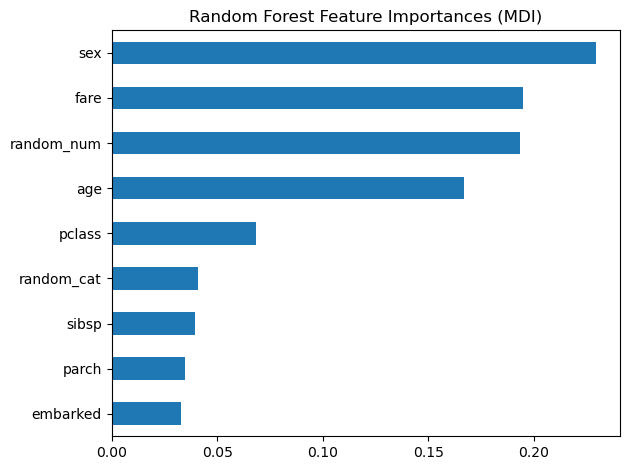

In [9]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()